In [618]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import operator
from keras.models import load_model
import time

In [197]:
def distance_between(p1, p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

In [198]:
def cut_from_rect(img, rect):
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]

In [419]:
def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    img = inp_img.copy()  # Copy the image, leaving the original untouched
    height, width = img.shape[:2]
    max_area = 0
    seed_point = (None, None)

    if scan_tl is None:
        scan_tl = [0, 0]

    if scan_br is None:
        scan_br = [width, height]
    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            if img.item(y, x) == 255 and x < width and y < height:  # Note that .item() appears to take input as y, x
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:  # Gets the maximum bound area which should be the grid
                    max_area = area[0]
                    seed_point = (x, y)
    
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv2.floodFill(img, None, (x, y), 64)
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, None, seed_point, 255)
    top, bottom, left, right = height, 0, width, 0
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    bbox = [[left, top], [right, bottom]]
    return bbox

In [420]:
def scale_and_centre(img, size, margin=0, background=0):
    h, w = img.shape[:2]

    def centre_pad(length):
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    _,img = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
    return cv2.resize(img, (size, size))

In [448]:
model=load_model("mnist_keras_cnn_model.h5")

In [479]:
def identify_number(image):
    image_resize = image.reshape(1,28,28,1)/255.0
    model_pred = model.predict_classes(image_resize, verbose = 0)
    return model_pred[0]

In [470]:
def digit_array(img,size):
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proc = cv2.bitwise_not(proc)  
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
    proc = cv2.dilate(proc, kernel)
    contours,h = cv2.findContours(proc.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    polygon = contours[0]
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in
                      polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in
                      polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in
                         polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in
                       polygon]), key=operator.itemgetter(1))
    top_left=polygon[top_left][0]
    bottom_left=polygon[bottom_left][0]
    bottom_right=polygon[bottom_right][0]
    top_right=polygon[top_right][0]
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32') 
    side = max([  distance_between(bottom_right, top_right), 
            distance_between(top_left, bottom_left),
            distance_between(bottom_right, bottom_left),   
            distance_between(top_left, top_right) ])
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
    m = cv2.getPerspectiveTransform(src, dst)
    img=cv2.warpPerspective(img, m, (int(side), int(side)))
    img=cv2.resize(img,(450,450))
    squares = [] 
    side = img.shape[:1] 
    side = side[0] / 9
    for j in range(9):
        for i in range(9):
            p1 = (i * side, j * side)  #Top left corner of a box   
            p2 = ((i + 1) * side, (j + 1) * side)  #Bottom right corner         
            squares.append((p1, p2))
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proc = cv2.bitwise_not(proc)
    digits = []
    digits_imgs=[]
    for square in squares:
        digit = cut_from_rect(proc, square)
        h, w = digit.shape[:2]
        margin = int(np.mean([h, w]) / 2.5)
        bbox= find_largest_feature(digit, [margin, margin], [w- margin, h - margin])
        digit = cut_from_rect(digit, bbox) 
        w = bbox[1][0] - bbox[0][0]
        h = bbox[1][1] - bbox[0][1]

        if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0 and digit.sum() > 25000:
            digits.append(identify_number(scale_and_centre(digit, size, 4)))
            digits_imgs.append(scale_and_centre(digit, size, 4))
        else:
            digits.append(0)
            digits_imgs.append(np.zeros((size, size), np.uint8))
    return digits,digits_imgs

In [646]:
def make_arr(digits):
    arr=[]
    for i in range(9):
        arr.append(digits[i*9:i*9+9])
    return arr

In [625]:
def show_grid(arr):
    for i in range(9):
        for j in range(9):
            print(arr[i][j],end=' ')
            if j==2 or j==5:
                print('|',end='')
        print()
    print('--------')

In [698]:
def show_digits(digits, colour=255):
    """Shows list of 81 extracted digits in a grid format"""
    rows = []
    with_border = [cv2.copyMakeBorder(img.copy(), 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, colour) for img in digits]
    for i in range(9):
        row = np.concatenate(with_border[i * 9:((i + 1) * 9)], axis=1)
        rows.append(row)
    img = np.concatenate(rows)
    return img

In [630]:
def check_horizontal(i,j,container):
    subtract_set = {1,2,3,4,5,6,7,8,9}
    return subtract_set - set(container[i])

def check_vertical(i, j,container):
    subtract_set = {1,2,3,4,5,6,7,8,9}
    ret_set = []
    for x in range(9):
        ret_set.append(container[x][j])
    return subtract_set - set(ret_set)

def check_square(i, j,container):
    subtract_set = {1,2,3,4,5,6,7,8,9}
    first = [0,1,2]
    second = [3,4,5]
    third = [6,7,8]
    find_square = [first, second, third]
    for l in find_square:
        if i in l:
            row = l
        if j in l:
            col = l
    return_set = []
    for x in row:
        for y in col:
            return_set.append(container[x][y])
    return subtract_set - set(return_set)
def get_poss_vals(i, j,container):
    poss_vals = list(check_square(i, j,container) \
                    .intersection(check_horizontal(i, j,container)) \
                    .intersection(check_vertical(i, j,container)))
    return poss_vals

In [631]:
def explicit_solver(container):
    stump_count=1
    for i in range(9):
        for j in range(9):
            if container[i][j] == 0:
                poss_vals = get_poss_vals(i,j,container)
                if len(poss_vals) == 1:
                    container[i][j] = list(poss_vals)[0]
                    show_grid(container)
                    stump_count = 0
    return stump_count

In [632]:
def implicit_solver(i, j, container):
    if container[i][j] == 0:
        poss_vals = get_poss_vals(i, j,container)
        #check_row
        row_poss = []
        for y in range(9):
            if y == j:
                continue
            if container[i][y] == 0:
                for val in get_poss_vals(i, y,container):
                    row_poss.append(val)
        if len(set(poss_vals)-set(row_poss)) == 1:
            container[i][j] = list(set(poss_vals)-set(row_poss))[0]
            show_grid(container)
            return
        #check column
        col_poss = []
        for x in range(9):
            if x == i:
                continue
            if container[x][j] == 0:
                for val in get_poss_vals(x, j,container):
                    col_poss.append(val)
        if len(set(poss_vals)-set(col_poss)) == 1:
            container[i][j] = list(set(poss_vals)-set(col_poss))[0]
            show_grid(container)
            return
        #check square
        first = [0, 1, 2]
        second = [3, 4, 5]
        third = [6, 7, 8]
        find_square = [first, second, third]
        for l in find_square:
            if i in l:
                row = l
            if j in l:
                col = l
        square_poss = []
        for x in row:
            for y in col:
                if container[x][y] == 0:
                    for val in get_poss_vals(x, y,container):
                        square_poss.append(val)
        if len(set(poss_vals)-set(square_poss)) == 1:
            container[i][j] = list(set(poss_vals)-set(square_poss))[0]
            show_grid(container)
            return
    return

In [716]:
def solve_sudoku(container):
    start = time.time()
    zero_count = 0
    for l in container:
        for v in l:
            if v == 0:
                zero_count += 1

    print(f'There are {zero_count} moves I have to make!')
    print()

    show_grid(container)
    print()
    solving = True


    while solving:
        #Solver Portion
        stump_count = explicit_solver(container)
        show_grid(arr)
        #Loop-Breaking Portion
        zero_count = 0
        for l in container:
            for v in l:
                if v == 0:
                    zero_count += 1
        if zero_count==0:
            show_grid(container)
            solving=False
        if stump_count > 0:
            for i in range(9):
                for j in range(9):
                    implicit_solver(i,j,container)
    print()
    print('That took', time.time()-start, 'seconds!')


In [638]:
solve_sudoku(arr)

There are 64 moves I have to make!

0 0 0 |0 0 0 |0 0 0 
0 0 0 |0 0 3 |0 8 5 
0 0 1 |0 2 0 |0 0 0 
0 0 0 |5 0 7 |0 0 0 
0 0 4 |0 0 0 |1 0 0 
0 9 0 |0 0 0 |0 0 0 
5 0 0 |0 0 0 |0 7 3 
0 0 2 |0 1 0 |0 0 0 
0 0 0 |0 4 0 |0 0 9 
--------

0 0 0 |0 0 0 |0 0 0 
0 0 0 |0 0 3 |0 8 5 
0 0 1 |0 2 0 |0 0 0 
0 0 0 |5 0 7 |0 0 0 
0 0 4 |0 0 0 |1 0 0 
0 9 0 |0 0 0 |0 0 0 
5 0 0 |0 0 0 |0 7 3 
0 0 2 |0 1 0 |0 0 0 
0 0 0 |0 4 0 |0 0 9 
--------
0 0 0 |0 5 0 |0 0 0 
0 0 0 |0 0 3 |0 8 5 
0 0 1 |0 2 0 |0 0 0 
0 0 0 |5 0 7 |0 0 0 
0 0 4 |0 0 0 |1 0 0 
0 9 0 |0 0 0 |0 0 0 
5 0 0 |0 0 0 |0 7 3 
0 0 2 |0 1 0 |0 0 0 
0 0 0 |0 4 0 |0 0 9 
--------
0 0 0 |0 5 0 |0 0 1 
0 0 0 |0 0 3 |0 8 5 
0 0 1 |0 2 0 |0 0 0 
0 0 0 |5 0 7 |0 0 0 
0 0 4 |0 0 0 |1 0 0 
0 9 0 |0 0 0 |0 0 0 
5 0 0 |0 0 0 |0 7 3 
0 0 2 |0 1 0 |0 0 0 
0 0 0 |0 4 0 |0 0 9 
--------
0 0 0 |0 5 0 |0 0 1 
0 0 0 |1 0 3 |0 8 5 
0 0 1 |0 2 0 |0 0 0 
0 0 0 |5 0 7 |0 0 0 
0 0 4 |0 0 0 |1 0 0 
0 9 0 |0 0 0 |0 0 0 
5 0 0 |0 0 0 |0 7 3 
0 0 2 |0 1 0 |0 0 0 
0 0

0 0 0 |0 4 5 |2 1 9 
--------
0 0 0 |0 5 4 |0 2 1 
2 4 6 |1 7 3 |9 8 5 
0 5 1 |0 2 8 |0 4 6 
1 2 8 |5 3 7 |6 9 4 
0 0 4 |0 9 0 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |0 8 0 |4 7 3 
4 0 2 |0 1 9 |5 6 8 
0 0 0 |0 4 5 |2 1 9 
--------
0 0 0 |0 5 4 |0 2 1 
2 4 6 |1 7 3 |9 8 5 
0 5 1 |0 2 8 |0 4 6 
1 2 8 |5 3 7 |6 9 4 
0 0 4 |0 9 2 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |0 8 0 |4 7 3 
4 0 2 |0 1 9 |5 6 8 
0 0 0 |0 4 5 |2 1 9 
--------
0 0 0 |0 5 4 |0 2 1 
2 4 6 |1 7 3 |9 8 5 
0 5 1 |0 2 8 |0 4 6 
1 2 8 |5 3 7 |6 9 4 
0 0 4 |0 9 2 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |0 8 6 |4 7 3 
4 0 2 |0 1 9 |5 6 8 
0 0 0 |0 4 5 |2 1 9 
--------
0 0 0 |0 5 4 |0 2 1 
2 4 6 |1 7 3 |9 8 5 
0 5 1 |0 2 8 |0 4 6 
1 2 8 |5 3 7 |6 9 4 
0 0 4 |0 9 2 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |0 8 6 |4 7 3 
4 0 2 |0 1 9 |5 6 8 
0 0 0 |0 4 5 |2 1 9 
--------
0 0 0 |0 5 4 |0 2 1 
2 4 6 |1 7 3 |9 8 5 
0 5 1 |9 2 8 |0 4 6 
1 2 8 |5 3 7 |6 9 4 
0 0 4 |0 9 2 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |0 8 6 |4 7 3 
4 0 2 |0 1 9 |5 6 8 
0 0 0 |0 4

In [705]:
def draw_sudoku(sudoku, digits):
    """
    Draws the given sudoku and returns the resulting image.
    If a source (unsolved sudoku) is given it will color the cells.
    """
    result = np.empty(shape=(450, 450, 3), dtype=np.uint8)
    result.fill(255)

    # vertical lines
    for x in range(1, 9):
        cv2.line(result, (50 * x, 0), (50 * x, 450), (0, 0, 0),
                 thickness=2 if x % 3 != 0 else 4)
    # horizontal lines
    for y in range(1, 9):
        cv2.line(result, (0, 50 * y), (450, 50 * y), (0, 0, 0),
                 thickness=2 if y % 3 != 0 else 4)

    for y, row in enumerate(sudoku):
        for x, value in enumerate(row):
            color = (0, 255, 0)
            # black text if the cell was part of the source sudoku
            if digits and digits[y * 9 + x]!=0:
                color = (0, 0, 0)
            cv2.putText(result, str(value), (x * 50 + 8, y * 50 + 50 - 8),
                        cv2.FONT_HERSHEY_COMPLEX, 1.5,
                        color, thickness=3)
    return result

In [738]:
def complete_solve(path):
    init_img=cv2.imread(path)
    img=cv2.imread(path,0)
    plt.imshow(cv2.cvtColor(init_img,cv2.COLOR_BGR2RGB))
    plt.title('Inital image')
    plt.figure(dpi=200)
    plt.show()
    digits,digits_imgs=digit_array(img,28)
    final_img=show_digits(digits_imgs)
    plt.imshow(final_img,cmap='gray')
    plt.title('Final processed image')
    plt.show()
    arr=make_arr(digits)
    solve_sudoku(arr)
    result=draw_sudoku(arr,digits)
    plt.imshow(result,cmap='gray')
    plt.title('Solved sudoku')
    plt.show()

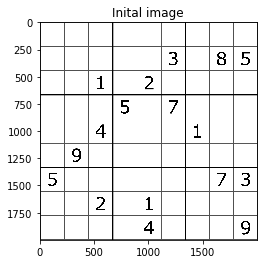

<Figure size 1200x800 with 0 Axes>

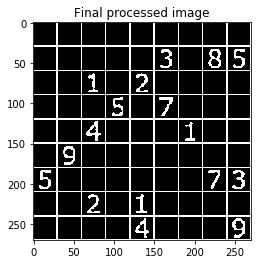

There are 64 moves I have to make!

0 0 0 |0 0 0 |0 0 0 
0 0 0 |0 0 3 |0 8 5 
0 0 1 |0 2 0 |0 0 0 
0 0 0 |5 0 7 |0 0 0 
0 0 4 |0 0 0 |1 0 0 
0 9 0 |0 0 0 |0 0 0 
5 0 0 |0 0 0 |0 7 3 
0 0 2 |0 1 0 |0 0 0 
0 0 0 |0 4 0 |0 0 9 
--------

9 8 7 |6 5 4 |3 2 1 
2 4 6 |1 7 3 |9 8 5 
3 5 1 |9 2 8 |7 4 6 
1 2 8 |5 3 7 |6 9 4 
6 3 4 |8 9 2 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |2 8 6 |4 7 3 
4 7 2 |3 1 9 |5 6 8 
8 6 3 |7 4 5 |2 1 9 
--------
0 0 0 |0 5 0 |0 0 0 
0 0 0 |0 0 3 |0 8 5 
0 0 1 |0 2 0 |0 0 0 
0 0 0 |5 0 7 |0 0 0 
0 0 4 |0 0 0 |1 0 0 
0 9 0 |0 0 0 |0 0 0 
5 0 0 |0 0 0 |0 7 3 
0 0 2 |0 1 0 |0 0 0 
0 0 0 |0 4 0 |0 0 9 
--------
0 0 0 |0 5 0 |0 0 1 
0 0 0 |0 0 3 |0 8 5 
0 0 1 |0 2 0 |0 0 0 
0 0 0 |5 0 7 |0 0 0 
0 0 4 |0 0 0 |1 0 0 
0 9 0 |0 0 0 |0 0 0 
5 0 0 |0 0 0 |0 7 3 
0 0 2 |0 1 0 |0 0 0 
0 0 0 |0 4 0 |0 0 9 
--------
0 0 0 |0 5 0 |0 0 1 
0 0 0 |1 0 3 |0 8 5 
0 0 1 |0 2 0 |0 0 0 
0 0 0 |5 0 7 |0 0 0 
0 0 4 |0 0 0 |1 0 0 
0 9 0 |0 0 0 |0 0 0 
5 0 0 |0 0 0 |0 7 3 
0 0 2 |0 1 0 |0 0 0 
0 0

0 0 4 |8 9 2 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |0 8 6 |4 7 3 
4 0 2 |0 1 9 |5 6 8 
0 0 0 |0 4 5 |2 1 9 
--------
0 0 0 |0 5 4 |0 2 1 
2 4 6 |1 7 3 |9 8 5 
0 5 1 |9 2 8 |0 4 6 
1 2 8 |5 3 7 |6 9 4 
0 0 4 |8 9 2 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |2 8 6 |4 7 3 
4 0 2 |0 1 9 |5 6 8 
0 0 0 |0 4 5 |2 1 9 
--------
9 8 7 |6 5 4 |3 2 1 
2 4 6 |1 7 3 |9 8 5 
3 5 1 |9 2 8 |7 4 6 
1 2 8 |5 3 7 |6 9 4 
6 3 4 |8 9 2 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |2 8 6 |4 7 3 
4 7 2 |3 1 9 |5 6 8 
8 6 3 |7 4 5 |2 1 9 
--------
0 0 0 |6 5 4 |0 2 1 
2 4 6 |1 7 3 |9 8 5 
0 5 1 |9 2 8 |0 4 6 
1 2 8 |5 3 7 |6 9 4 
0 0 4 |8 9 2 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |2 8 6 |4 7 3 
4 0 2 |0 1 9 |5 6 8 
0 0 0 |0 4 5 |2 1 9 
--------
0 0 0 |6 5 4 |0 2 1 
2 4 6 |1 7 3 |9 8 5 
3 5 1 |9 2 8 |0 4 6 
1 2 8 |5 3 7 |6 9 4 
0 0 4 |8 9 2 |1 5 7 
7 9 5 |4 6 1 |8 3 2 
5 1 9 |2 8 6 |4 7 3 
4 0 2 |0 1 9 |5 6 8 
0 0 0 |0 4 5 |2 1 9 
--------
0 0 0 |6 5 4 |0 2 1 
2 4 6 |1 7 3 |9 8 5 
3 5 1 |9 2 8 |7 4 6 
1 2 8 |5 3 7 |6 9 4 
0 0 4 |8 9

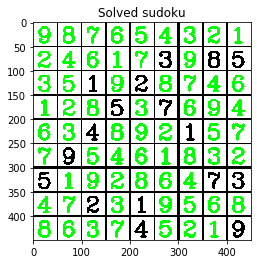

In [745]:
complete_solve('sudokupic2.png')